# Part 3 (a)

In `lora_skeleton.py` we defined `LoRALinear`, wrapped `q_proj` and `v_proj` in Qwn2.5 layers. We also freezed base model, i.e. only LoRA matrices (`A`, `B`) are trainable. Both dara processing and tokenisation are taken into account. Furthermore, the `Accelerator` package is implemented, this will accelerate training loop (as it allows GPU to process data). Also Traning and Validation sequences are prepped in `preprocessor.py`.

To wrap it up, everything is ready to go!

## LoRA Parameter Tuning Explained

To efficiently fine-tune the Qwen2.5-0.5B model on time-series data, we use Low-Rank-Adaptation (LoRA), a parameter efficient approach that avoids updating the full weight matrices of a large language model.

In our steps, we include:
- only the LoRA matrices `A` and `B` are trained.
- These are small learnable projections inserted into the query (`q_proj`) and value (`v_proj`) layers of each Transformer attention block.

### How LoRA Mechanics Works

Instead of modifying the original projection matrix $W$, LoRA decomposes a low-rank update into:
$$
\Delta W = B \cdot A
$$
Where:
- $A \in \mathbb{R}^{r\times d_{in}}$
- $B \in \mathbb{R}^{d_{out}\times r}$
- $r<<d$, making the update lightweight

We freeze all original model parameters, including:
- Qwen's base Transformer weights
- Language model head (exept for bias)
- Token embeddings and positional encodings

Hence, the only trainable parameters are:
1. The LoRA matricas `A` and `B` (in `q_proj` and `v_proj`)
2. The bias term in the LM head (explicitly made trainable)

Resulting in a drastic reduction in the number of learnable parameters, making training feasible with limited resources while still enabling meaningful adaptation of the model to the new tasks


### Evaluating LoRA Untrained Performance

Just like we did in `Baseline.ipynb` (Part 2(b)), where we tested untrained Qwen2.5, here we are doing the same, but this time with the Qwen2.5 model modified to include LoRA adapters. This is useful, as it will provide a baseline for the untrained LoRA performance, so we can later compare it to the trained LoRA model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessor import*
from src.plotting import*
from sklearn.metrics import mean_absolute_error


In [2]:
import torch
# Set seed
torch.manual_seed(23)

We had to define a new "lighter" Python file (`minimal_lora_eval.py) for LoRA, since the original one has evrything we need for training, and I cannot train LoRA on my machine as my GPU does not have enough vram to support it (my laptop has a NVIDIA GeForce RTX 3070, with 8GB of vram, and at leat 20 are required!)

In [3]:
from src.minimal_lora_eval import model, tokenizer

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
# Rename to not get confused with qwen modle and tokenizer
model_lora = model.to('cuda') # connect to GPU
tokenizer_lora = tokenizer

Quick check to see if LoRA was successuflly injected

In [5]:
print(type(model_lora.model.layers[0].self_attn.q_proj)) # checking if LoRA is successfully injected to qwen

layer = model_lora.model.layers[0].self_attn.q_proj
if hasattr(layer, "A") and hasattr(layer, "B"):
    print("YES, LoRA is injected.")
else:
    print("NO! LoRA not found in q_proj.")


<class 'src.minimal_lora_eval.LoRALinear'>
YES, LoRA is injected.


In [6]:
print(next(model_lora.parameters()).device) # check if you successfully activated the GPU

cuda:0


Just like in the other notebook (`Baseline.ipynb`), we need to preprocess the data

Scale and convert time-serie data to string

In [7]:
# Loading and preprocessig data

train_texts, val_texts, val_texts_70 = load_and_preprocess('data/lotka_volterra_data.h5')

# Split and scale data, this will be used for comparison
traj_train, traj_val, traj_val_70 = data_scale_split('data/lotka_volterra_data.h5')

Tokenisation

In [8]:
# Import tokenize_time_series_np
from src.qwen import*

In [9]:
# Tokeniseing data series
tok_train_texts = tokenize_time_series_np(train_texts)
tok_val_texts = tokenize_time_series_np(val_texts)
tok_val_texts_70 = tokenize_time_series_np(val_texts_70)

In [10]:
def sequence_length_array(tokenized_string):
    """
    Computes the sequence lengths for a list of tokenized inputs.

    This function takes a list of tokenized input dictionaries (as returned by a Hugging Face tokenizer 
    with `return_tensors="pt"`), and extracts the length (number of tokens) for each input sequence.

    Parameters:
    -----------
    tokenized_string : list of dict
        A list where each item is a dictionary containing tokenized data with at least the key 
        'input_ids', whose value is a tensor of shape (1, sequence_length).

    Returns:
    --------
    max_lengths : np.ndarray
        A 1D NumPy array containing the sequence lengths (number of tokens) for each input.

    Example:
    --------
    >>> tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
    >>> encoded = [tokenizer(text, return_tensors="pt") for text in text_list]
    >>> lengths = sequence_length_array(encoded)
    """
    max_lengths = np.array([entry["input_ids"].shape[1] for entry in tokenized_string])
    return max_lengths

In [11]:
# Determining full lengths of full tokenised validation set
full_tok_val_lengths = sequence_length_array(tok_val_texts)
input_ids_list = [tok_val_texts_70[i]["input_ids"].to(model_lora.device) for i in range(len(tok_val_texts_70))]
attention_masks_list = [tok_val_texts_70[i]["attention_mask"].to(model_lora.device) for i in range(len(tok_val_texts_70))]

Experiment for single system

In [12]:
output_sigle_system = model_lora.generate(input_ids_list[0], # Sequence, numerical tokens
                        attention_mask = attention_masks_list[0], # 
                        max_length = full_tok_val_lengths[0], # Maximum length of generated output
                        num_return_sequences=1, # Number of prediction to return per input
                        do_sample=True, # Enables sampling (i.e. introduces randomness)
                        temperature=0.7, # Controls randomness of predictions
                        top_p=0.8, # Nucleus sampling (filters low-probability tokens)
                        top_k=20 # Limits the number of token options at each step
                        )

In [13]:
decoded_single_system = tokenizer_lora.decode(output_sigle_system[0], skip_special_tokens=True)
len(decoded_single_system)

1199

Untrained LoRA for all 100 systems in `tok_val_text_70`, remeber we are trying to predict the remaining 30 pairpoints

In [14]:
output_list = []
for i in range(len(tok_val_texts_70)):
    output = model_lora.generate(input_ids_list[i], # Sequence, numerical tokens
                            attention_mask = attention_masks_list[i], # 
                            max_length = full_tok_val_lengths[i], # Maximum length of generated output
                            num_return_sequences=1, # Number of prediction to return per input
                            do_sample=True, # Enables sampling (i.e. introduces randomness)
                            temperature=0.7, # Controls randomness of predictions
                            top_p=0.8, # Nucleus sampling (filters low-probability tokens)
                            top_k=20 # Limits the number of token options at each step
                            )
    output_list.append(output)

Same as before we are going to decode the outputs

In [15]:
decoded_output_list = []

for i in range(len(tok_val_texts_70)):
    decoded_output = tokenizer.decode(output_list[i][0], skip_special_tokens=True)
    decoded_output_list.append(decoded_output)

And convert the decoded output back to time series format.

In [16]:
string_to_array_list = []

for i in range(len(tok_val_texts_70)):
    decoded_to_number = string_to_array(decoded_output_list[i])
    string_to_array_list.append(decoded_to_number)

Save the resuls

In [ ]:
#my_decoded_predictions = string_to_array_list
#type(my_decoded_predictions)
#np.savez("experiment_results/untrained_qwen_plus_lora_results/my_decoded_predictions.npz", *my_decoded_predictions)

### Determining Metrics

For a valid comparison, we are going to evaluate the same metrics determined for Qwen2.5 model's forecasting ability, namely MSE, RMSE and pair-point errors within each system

In [17]:
predicted_output = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(string_to_array_list)):
    sub_output = string_to_array_list[i]
    sub_output_min_30 = sub_output[70:]
    true_v = traj_val[i]
    true_v_min_30 = true_v[70:]
    predicted_output.append(sub_output_min_30)
    true_values.append(true_v_min_30)

#### MSE

In [18]:
MSE_values = []


for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values.append([mse_prey, mse_predator])

Save MSE results

In [ ]:
#MSE_loaded = np.save("experiment_results/untrained_qwen_plus_lora_results/MSE_values_3a.npy", np.array(MSE_values))

#### RMSE

In [20]:
RMSE_values = np.sqrt(MSE_values)

#Saving results
#np.save('experiment_results/untrained_qwen_plus_lora_results/RMSE_values_3a', RMSE_values)

# Load back if necessary
# RMSE_loaded = np.load("experiment_results/untrained_qwen_plus_lora_results/RMSE_values_3a.npy")

Collecting MSE and RMSE results into `pandas.DataFrames`, as the designed function for plotting MSE and RMSE Histograms takes `panda.DataFrame` as inputs. 

In [21]:
df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "MSE for prey": np.array(MSE_values)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values)[:, 1]  # Flatten predator values
})
df_RMSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "RMSE for prey": RMSE_values[:, 0],  # Flatten prey values
    "RMSE for predator": RMSE_values[:, 1]  # Flatten predator values
})

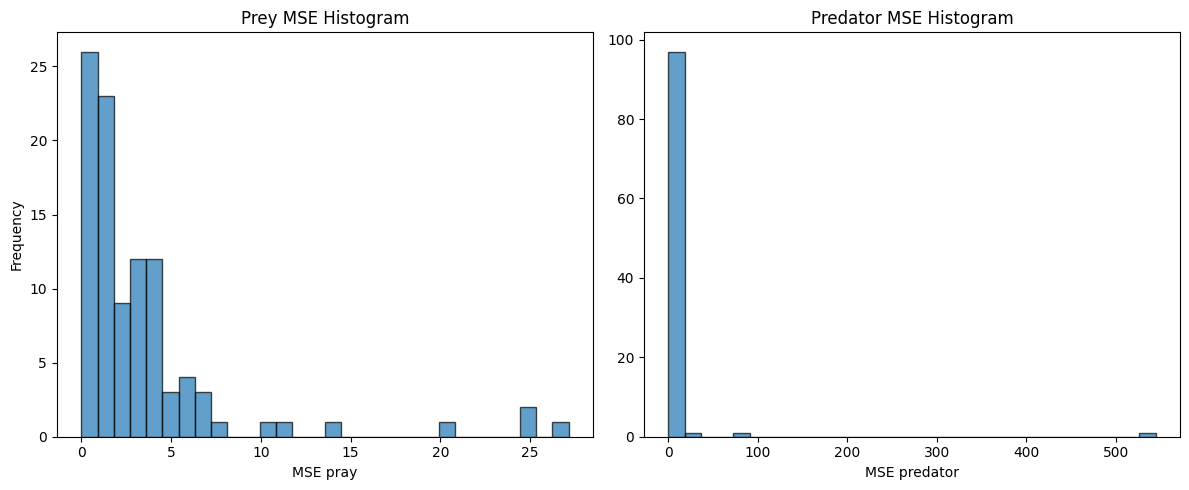

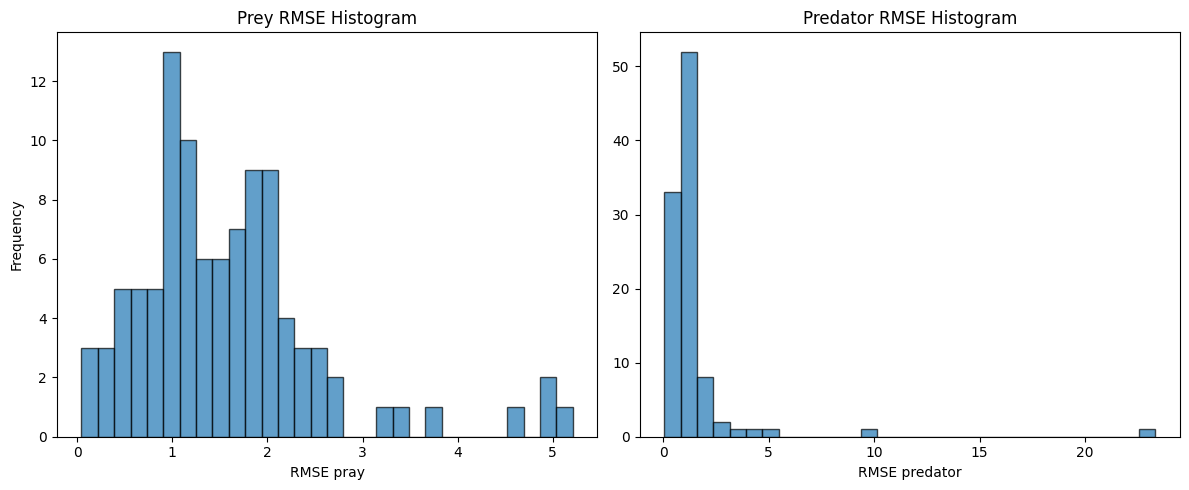

In [22]:
from src.plotting import PlotProject
PlotProject.plot_hist_MSE(df_MSE_values,bins=30) # Plotting MSE distribution
PlotProject.plot_hist_RMSE(df_RMSE_values,bins=30) # Plotting RMSE distribution

#### Histogram of Error Mean

In [23]:
# Computing the error for each system

error_per_system = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Computing errors
    prey_error = true_val[:,0] - pr_out[:,0]
    predator_error = true_val[:,1] - pr_out[:,1]
    
    # Collecting errors into a list
    error_per_system.append([prey_error, predator_error])

print('Length of error_per_system:',len(error_per_system))

# Saving system as 
#np.savez("experiment_results/untrained_qwen_plus_lora_results/error_per_system.npz", *error_per_system)

Length of error_per_system: 100


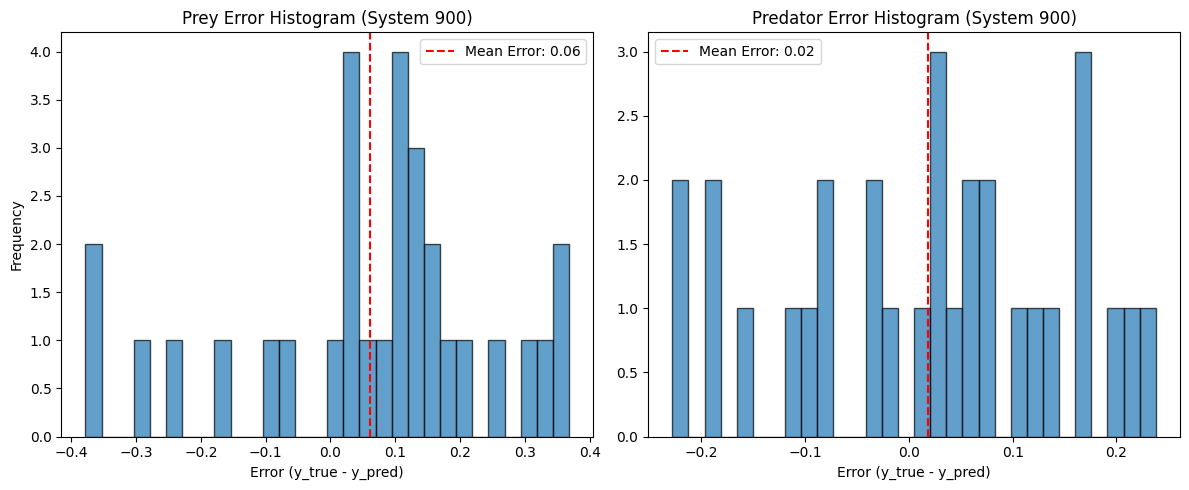

In [24]:
# Print as many historgrams as you want from 0-99.

PlotProject.plot_error_hist_system(error_per_system, system_id=0, bins=30)

Visualising one of the 100 predicted systems vs its true values.

Decoded prediction shape: (100, 2)
True dataset shape: (100, 2)


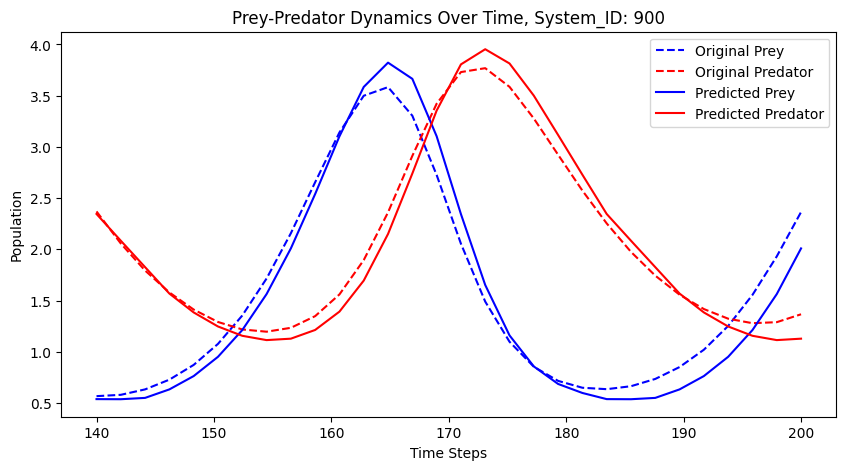

: 

In [ ]:
pred_vs_true_visualisation(string_to_array_list, traj_val, 0)